## Kelly Criterion 
[(ref)](https://medium.com/@The-Quant-Trading-Room/the-ultimate-trading-strategy-how-to-combine-kelly-criteria-and-monte-carlo-simulation-d9ce8cc2c2bc)
Let $f$ be the percentage of total capital one decides to bet and $1-f$ be the percentage of the capital to be invested to a bank with interest rate $r>0$. Suppose the return rate $X$ follows $\mathcal{N}(\mu,\sigma^2)$,
we consider the maximization of expected log wealth over the fraction $f$ and the optimal fraction:
$$
\sup_{f \in \mathbb{R}}E(\ln(1+fX+ (1-f)r)) \; \Rightarrow \; f^* = \frac{\mu-r}{\sigma^2}
$$
We can run simulation for the price path and see the performance of Kelly criterion for long peroids
or run the backtest for the given input data. We can also include some conditions , e.g fractional Kelly(only invest $\alpha f^*$ for some $\alpha \in (0,1)$ ) or leverage limit ( $f^* \wedge k$ for some integer $k>1$).

input : log return $x_t$ from data or random generated, output: growth rate sequence 
$\{\prod_{s=1}^t(1+f^* x_s + (1-f^*)r)\}_{t \geq 1}$

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def kelly(return_array,rate,kelly_cap,kelly_frac):
    mu = np.mean(return_array)
    var = np.var(return_array)
    if kelly_cap == False: #no restricion for leverage
        f_opt = (mu-rate)/var *kelly_frac  #allow shorting , f_opt can be negative
    else:
        f_opt = min((mu-rate)/var ,kelly_cap)*kelly_frac 
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        growth_array[s] = (1+f_opt*return_array[s] + (1-f_opt)*rate)
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array

### Simulation
We consider different fractional Kelly criterions and compare them and other strategies like buy and hold or arbitrary chosen weight for rebalancing.


Suppose the interest rate for one year is $4\%$, mean of
daily return is $0$ , standard deviation of daily return is $0.01$. We run the Kelly criterions daily for $10000$ days (~ $27$ years) with $\alpha = 1 , 0.8 , 0.5 , 0.2$, buying $50\%$ and holds, buying $100\%,50\% ,0\% $ and
rebalancing.

B&H =$\{\frac{1}{2} \prod_{s=1}^t (1+x_s) + \frac{1}{2}\prod_{s=1}^t (1+r)\}_{t\geq 1}$ 

arbitrary weight = $\{\prod_{s=1}^t(1+\theta x_s + (1-\theta)r)\}_{t \geq 1}$ for some $\theta \in [0,1]$

In [20]:
def BnH(return_array,rate):
    wealth_array = np.ones(len(return_array)+1)
    stock=0.5
    bank=0.5
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        stock=stock*(1+return_array[s])
        bank= bank*(1+rate)
        wealth_array[s+1]= stock+bank
        growth_array[s] = wealth_array[s+1]/wealth_array[s]
    return wealth_array,growth_array
def arbitrary(return_array,rate,ratio):
    wealth_array = np.ones(len(return_array)+1)
    growth_array = np.zeros_like(return_array)
    for s in range(len(return_array)):
        growth_array[s] = (1+ratio*return_array[s] + (1-ratio)*rate)
        wealth_array[s+1] = wealth_array[s]*growth_array[s]
    return wealth_array,growth_array

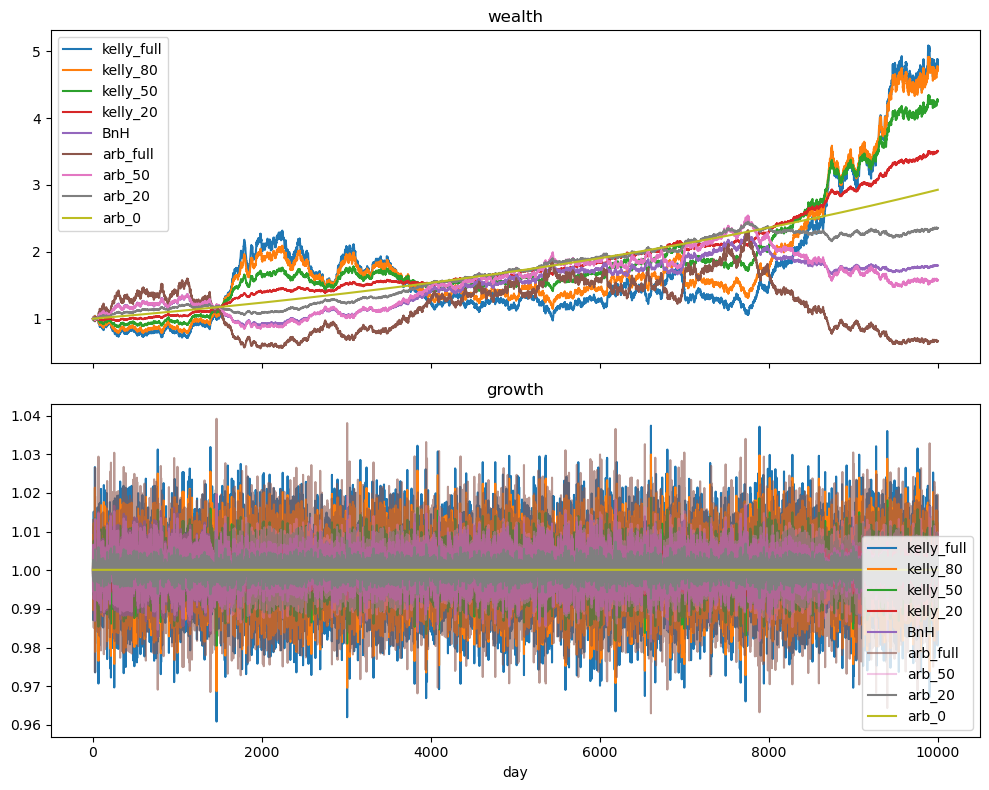

In [225]:
r = (1+0.04)**(1/365) -1
return_array = np.random.normal(0,0.01,10000)

kelly_full,growth_kelly_full = kelly( return_array,r,False,1)
kelly_80,growth_kelly_80 = kelly( return_array,r,False,0.8)
kelly_50,growth_kelly_50 = kelly( return_array,r,False,0.5)
kelly_20,growth_kelly_20 = kelly( return_array,r,False,0.2)
BnH_array,growth_BnH = BnH(return_array,r)
arb_full, growth_arb_full=arbitrary(return_array,r,1)
arb_50, growth_arb_50=arbitrary(return_array,r,0.5)
arb_20, growth_arb_20=arbitrary(return_array,r,0.2)
arb_0, growth_arb_0=arbitrary(return_array,r,0)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))

ax[0].plot(kelly_full,label="kelly_full")
ax[0].plot(kelly_80,label="kelly_80")
ax[0].plot(kelly_50,label="kelly_50")
ax[0].plot(kelly_20,label="kelly_20")
ax[0].plot(BnH_array,label="BnH")
ax[0].plot(arb_full,label="arb_full")
ax[0].plot(arb_50,label="arb_50")
ax[0].plot(arb_20,label="arb_20")
ax[0].plot(arb_0,label="arb_0")
ax[0].set_title('wealth')

ax[1].plot(growth_kelly_full,label="kelly_full")
ax[1].plot(growth_kelly_80,label="kelly_80")
ax[1].plot(growth_kelly_50,label="kelly_50")
ax[1].plot(growth_kelly_20,label="kelly_20")
ax[1].plot(growth_BnH,label="BnH")
ax[1].plot(growth_arb_full,label="arb_full",alpha=0.6)
ax[1].plot(growth_arb_50,label="arb_50",alpha=0.4)
ax[1].plot(growth_arb_20,label="arb_20")
ax[1].plot(growth_arb_0,label="arb_0")
ax[0].legend()
ax[1].legend()
ax[1].set_title('growth')
ax[1].set_xlabel('day')
plt.tight_layout()

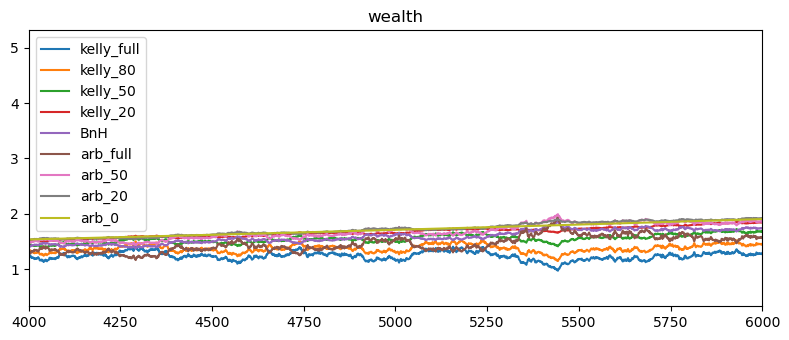

In [231]:
plt.figure(figsize=(8,3.5))
plt.plot(kelly_full,label="kelly_full")
plt.plot(kelly_80,label="kelly_80")
plt.plot(kelly_50,label="kelly_50")
plt.plot(kelly_20,label="kelly_20")
plt.plot(BnH_array,label="BnH")
plt.plot(arb_full,label="arb_full")
plt.plot(arb_50,label="arb_50")
plt.plot(arb_20,label="arb_20")
plt.plot(arb_0,label="arb_0")
plt.title('wealth')

plt.legend()
plt.xlim(4000,6000)
plt.tight_layout()

From the graph, we can see that full kelly gives the largest wealth in the end, but its fluctuation of growth is also very large. Furthermore, in some range, full kelly has even the worst performance compared with others
Also, it seems that BnH strategy is even worst than arb_0 (deposits all in the bank).

### Backtest
Here we use ETF daily price  and US Treasury rate (one month maturity) from 2017/8/17 to 2023/10/26. We consider the time interval with length 90 days for computing the moving average, variance and updating the optimal allocation $f^*$.

In [192]:
rate = pd.read_csv('input data/Treasury_data.csv')

from download_binance import * 
symbols = ["ETH"]
period = "1d"
start = datetime.datetime(2017, 8,  17, 0, 0)
end   = datetime.datetime(2023, 10, 26, 0, 0)

for i, symbol in enumerate( symbols[:] ):

    print(f"Begin downloading: H1-{symbol}")
    df = get_data_since(symbol, start, end, period )
    print(f"Download completed: H1-{symbol}")

In [210]:
rate

,date,1m
0,2017-08-17,0.95
1,2017-08-18,0.97
2,2017-08-21,0.95
3,2017-08-22,0.93
4,2017-08-23,0.98
...,...,...
1539,2023-10-13,5.60
1540,2023-10-16,5.57
1541,2023-10-17,5.58
1542,2023-10-18,5.57


In [194]:
df

,timestamp,open,high,low,close,volume
0,2017-08-17,301.13,312.18,298.00,302.00,7030.71034
1,2017-08-18,302.00,311.79,283.94,293.96,9537.84646
2,2017-08-19,293.31,299.90,278.00,290.91,2146.19773
3,2017-08-20,289.41,300.53,282.85,299.10,2510.13871
4,2017-08-21,299.10,346.52,294.60,323.29,5219.44542
...,...,...,...,...,...,...
2260,2023-10-25,1784.98,1817.69,1760.00,1787.15,354410.82940
2261,2023-10-26,1787.15,1865.54,1762.21,1803.38,431169.04530
2262,2023-10-27,1803.39,1803.91,1744.66,1779.40,274532.69210
2263,2023-10-28,1779.41,1803.23,1770.00,1776.20,122919.73820


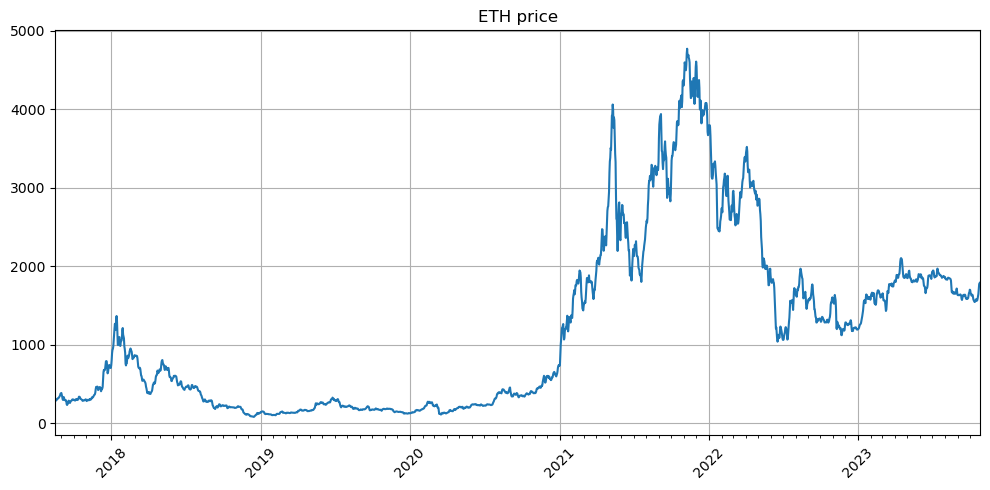

In [211]:
time = np.array([df.loc[t,'timestamp'] for t in range( len(df['timestamp']) ) ])
window = 90
df['price']=(df["open"]+df["close"])/2
df['returns']= np.log(df['price'])-np.log(df['price']).shift(1)
df['mean']=df['returns'].rolling(window).mean()
df['std']=df['returns'].rolling(window).std()

price_array = df.loc[:,'price'].values
return_array = df.loc[window:,'returns'].values
mean_array= df.loc[:,'mean'].dropna().values
std_array= df.loc[:,'std'].dropna().values

from matplotlib.dates import *
fig,ax = plt.subplots(figsize=(10,5))
ax.plot(time,price_array)
ax.tick_params(axis='x',rotation=45)
ax.xaxis.set_minor_locator(MonthLocator())
ax.set_xlim(start,end)
ax.set_title("ETH price")
plt.tight_layout()
ax.grid()

Since the dates of price data and treasury rates data doesn't match, here for simplicity we
partition the rates data into same amount

In [197]:
df['returns']

0            NaN
1      -0.011959
2      -0.019896
3       0.007316
4       0.055973
          ...   
2260    0.006088
2261    0.005138
2262   -0.002158
2263   -0.007615
2264    0.004733
Name: returns, Length: 2265, dtype: float64

In [222]:
rate

,1m
date,
2017-08-17,0.95
2017-08-18,0.97
2017-08-21,0.95
2017-08-22,0.93
2017-08-23,0.98
...,...
2023-10-13,5.60
2023-10-16,5.57
2023-10-17,5.58


In [ ]:
r = (1+0.04)**(1/365) -1
return_array = np.random.normal(0,0.01,10000)

kelly_full,growth_kelly_full = kelly( return_array,r,False,1)
kelly_80,growth_kelly_80 = kelly( return_array,r,False,0.8)
kelly_50,growth_kelly_50 = kelly( return_array,r,False,0.5)
kelly_20,growth_kelly_20 = kelly( return_array,r,False,0.2)
BnH_array,growth_BnH = BnH(return_array,r)
arb_full, growth_arb_full=arbitrary(return_array,r,1)
arb_50, growth_arb_50=arbitrary(return_array,r,0.5)
arb_20, growth_arb_20=arbitrary(return_array,r,0.2)
arb_0, growth_arb_0=arbitrary(return_array,r,0)

fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,8))

ax[0].plot(kelly_full,label="kelly_full")
ax[0].plot(kelly_80,label="kelly_80")
ax[0].plot(kelly_50,label="kelly_50")
ax[0].plot(kelly_20,label="kelly_20")
ax[0].plot(BnH_array,label="BnH")
ax[0].plot(arb_full,label="arb_full")
ax[0].plot(arb_50,label="arb_50")
ax[0].plot(arb_20,label="arb_20")
ax[0].plot(arb_0,label="arb_0")
ax[0].set_title('wealth')

ax[1].plot(growth_kelly_full,label="kelly_full")
ax[1].plot(growth_kelly_80,label="kelly_80")
ax[1].plot(growth_kelly_50,label="kelly_50")
ax[1].plot(growth_kelly_20,label="kelly_20")
ax[1].plot(growth_BnH,label="BnH")
ax[1].plot(growth_arb_full,label="arb_full",alpha=0.6)
ax[1].plot(growth_arb_50,label="arb_50",alpha=0.4)
ax[1].plot(growth_arb_20,label="arb_20")
ax[1].plot(growth_arb_0,label="arb_0")
ax[0].legend()
ax[1].legend()
ax[1].set_title('growth')
ax[1].set_xlabel('day')
plt.tight_layout()